# Facial recognition to detect mood

### Dataset of 
* **Diminsion**:  32x32 pixel grayscale images basic math operators and number
* **Target:** ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']). The training set .

<div style="text-align: center;">
  <img src="https://cdn1.iconfinder.com/data/icons/mathematics/66/66-512.png" width="200" height="50">
</div>

# Importing
### Import library

In [47]:
"""Import library""" 
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50V2 as ResNet
from tensorflow.keras.callbacks import EarlyStopping,  ReduceLROnPlateau
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 28)

import random
import os

!pip install imutils
import imutils
from imutils.contours import sort_contours

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25838 sha256=0860cb75f6746493f341545f3798dfe401c87c8564b70d640299c6d88100b39d
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


### Import dataset

In [3]:
def extractImages(datadir):
    # Get the data
    imagesData = []
    imagesLabel = []
    for folder in os.listdir(datadir):
        path = os.path.join(datadir, folder)
        for images in os.listdir(path):
            img = cv2.imread(os.path.join(path, images), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (32, 32))
            imagesData.append(img)
            imagesLabel.append(folder)
            
    # Shuffle data
    combined = list(zip(imagesData, imagesLabel))
    random.shuffle(combined)
    imagesData, imagesLabel = zip(*combined)
    
    return (imagesData, imagesLabel)

In [4]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/data.zip
!unzip -qo data.zip

--2023-10-29 14:47:43--  https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/data.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.156.159, 52.219.156.139, 52.219.62.16, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.156.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28437489 (27M) [application/x-zip-compressed]
Saving to: ‘data.zip’

data.zip            100%[===================>]  27.12M  7.95MB/s    in 3.4s    

2023-10-29 14:47:47 (7.95 MB/s) - ‘data.zip’ saved [28437489/28437489]



In [6]:
# Import train data
imagesData = []
imagesLabel = []
train_data_dir = '/kaggle/working/data/dataset'

imagesData, imagesLabel = extractImages(train_data_dir)

print("number of image: ",len(imagesData))        
print("shape of image:  ",imagesData[1].shape)
print("labels:          ",list(set(imagesLabel)))

number of image:  7600
shape of image:   (32, 32)
labels:           ['sub', '5', 'div', '3', '9', '8', '7', '4', '0', '2', '6', '1', 'add', 'mul']


In [7]:
imagesTrainData, imagesTestData, imagesTrainLabel, imagesTestLabel = train_test_split(
                                                                                    imagesData,imagesLabel, 
                                                                                    shuffle=True, 
                                                                                    test_size=0.2, 
                                                                                    random_state=42,
                                                                                    stratify= imagesLabel )

---
# Data Exploring
### Show Dataset Image

In [71]:
# Show Image
def showImage (images,label,part):
    figure = plt.figure(figsize=((len(part)/10 + 1)*10, (len(part)/10 + 1)*2))
    j = 0
    for i in part:
        lbl = label[i]
        img = images[i]
        img = cv2.resize(img, (256, 256))
        figure.add_subplot(int(len(part)/10)+1, 10, j+1)
        plt.imshow(img,cmap='gray')
        plt.axis('off')
        plt.title(lbl)
        j += 1

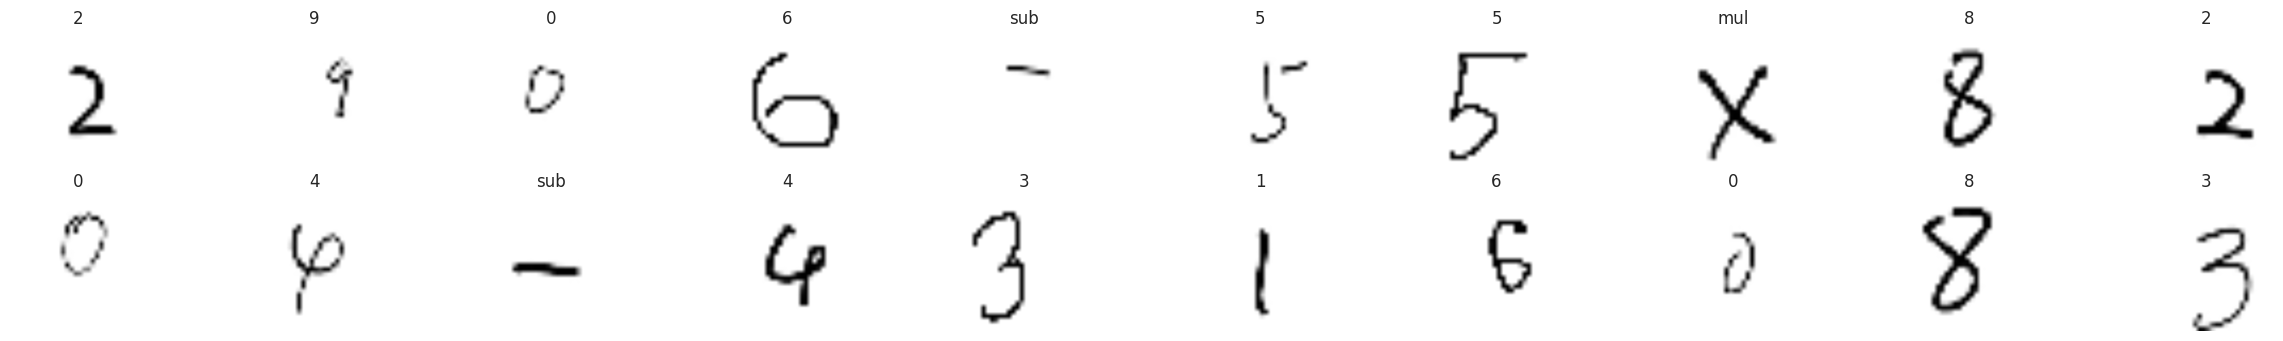

In [72]:
showImage(imagesTrainData,imagesTrainLabel, range(20))

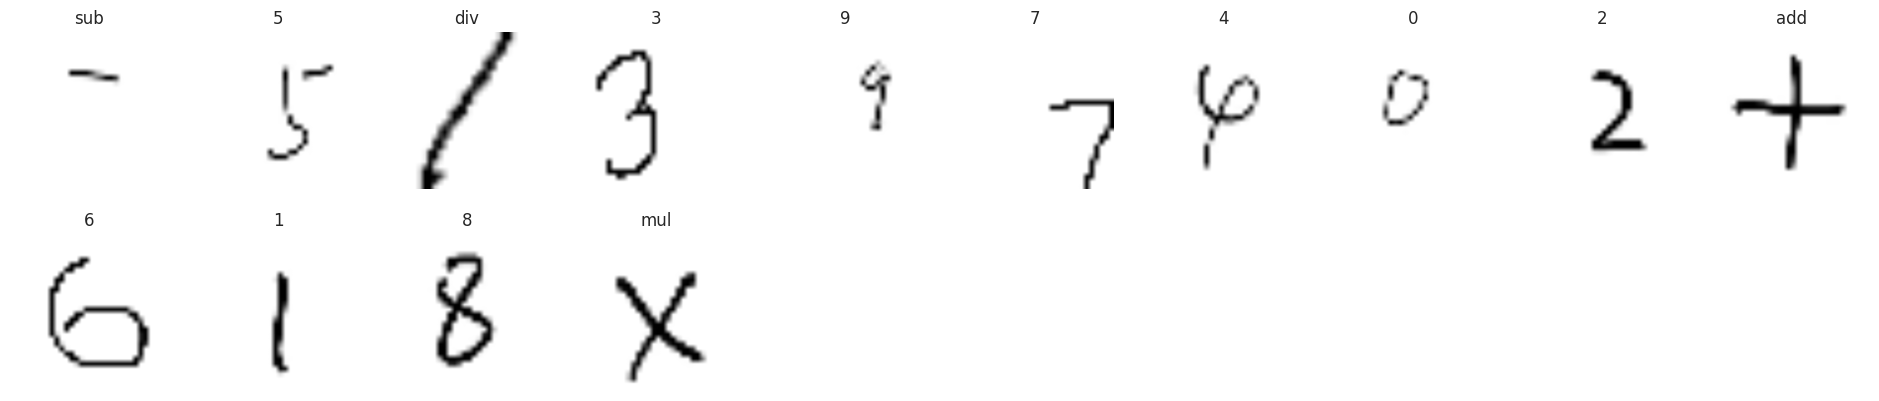

In [73]:
unique_idx = [imagesTrainLabel.index(i) for i in list(set(imagesTrainLabel))]
showImage(imagesTrainData,imagesTrainLabel, unique_idx )

### Visualizing the Distribution of Images

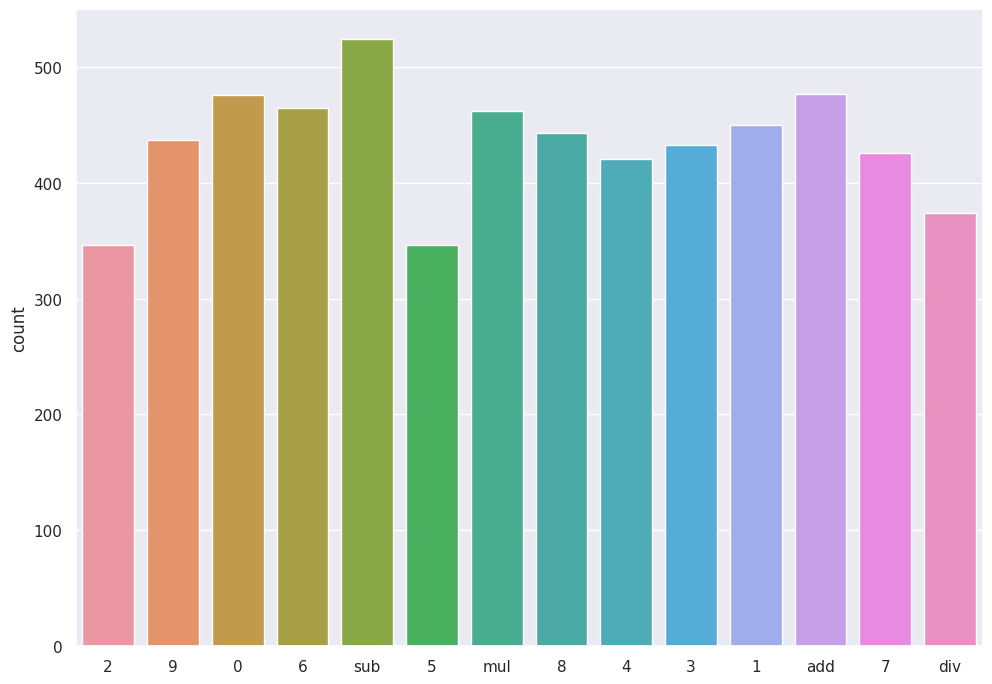

In [12]:
sns.countplot(x= list(imagesTrainLabel));

we can see data nearly balanced

---
# Preprocessing


### Encoding

In [13]:
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(imagesTrainLabel)
Y_test = label_encoder.transform(imagesTestLabel)

In [14]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

### Scaling

In [15]:
X_train = np.array(imagesTrainData)
X_test = np.array(imagesTestData)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6080, 32, 32, 1)
(1520, 32, 32, 1)
(6080, 14)
(1520, 14)


In [16]:
X_train[0].shape

(32, 32, 1)

---
# CNN Model

In [22]:
def facial_recognition_detect_mood(input_shape=(32, 32, 1)):
   
    
    model = Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(14, activation='softmax'))

    model.compile(optimizer=Adam(lr=0.0001,), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [23]:
model = facial_recognition_detect_mood()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       36992     
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 128)     

In [27]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('HandwrittenMathEquationModel.h5', 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             verbose=1, 
                             mode='min')

earlyStopping = EarlyStopping(monitor='val_accuracy', 
                              mode='auto', 
                              verbose=1, 
                              patience=10, 
                              restore_best_weights=True)

reduceLr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)

callbacks = [checkpoint,earlyStopping,reduceLr, LearningRateScheduler(step_decay)]

In [28]:
# Image Augmentation 
aug = ImageDataGenerator(zoom_range=0.1,
                         rotation_range=5,
                         width_shift_range=0.05,
                         height_shift_range=0.05)

In [29]:
hist = model.fit(aug.flow(X_train, Y_train, batch_size=64), batch_size=64, epochs=90, validation_data=(X_test, Y_test), callbacks=callbacks)

Epoch 1/90
95/95 [==============================] - ETA: 0s - loss: 1.2666 - accuracy: 0.7023
Epoch 1: val_accuracy improved from inf to 0.13684, saving model to HandwrittenMathEquationModel.h5
95/95 [==============================] - 15s 163ms/step - loss: 1.2666 - accuracy: 0.7023 - val_loss: 18.6780 - val_accuracy: 0.1368 - lr: 0.0010
Epoch 2/90
95/95 [==============================] - ETA: 0s - loss: 0.9753 - accuracy: 0.7704
Epoch 2: val_accuracy did not improve from 0.13684
95/95 [==============================] - 15s 153ms/step - loss: 0.9753 - accuracy: 0.7704 - val_loss: 13.3120 - val_accuracy: 0.2520 - lr: 0.0010
Epoch 3/90
95/95 [==============================] - ETA: 0s - loss: 0.8420 - accuracy: 0.8038
Epoch 3: val_accuracy did not improve from 0.13684
95/95 [==============================] - 15s 158ms/step - loss: 0.8420 - accuracy: 0.8038 - val_loss: 6.3777 - val_accuracy: 0.4928 - lr: 0.0010
Epoch 4/90
95/95 [==============================] - ETA: 0s - loss: 0.7244 - ac

In [30]:
model.save('HandwrittenMathEquationModel.h5')

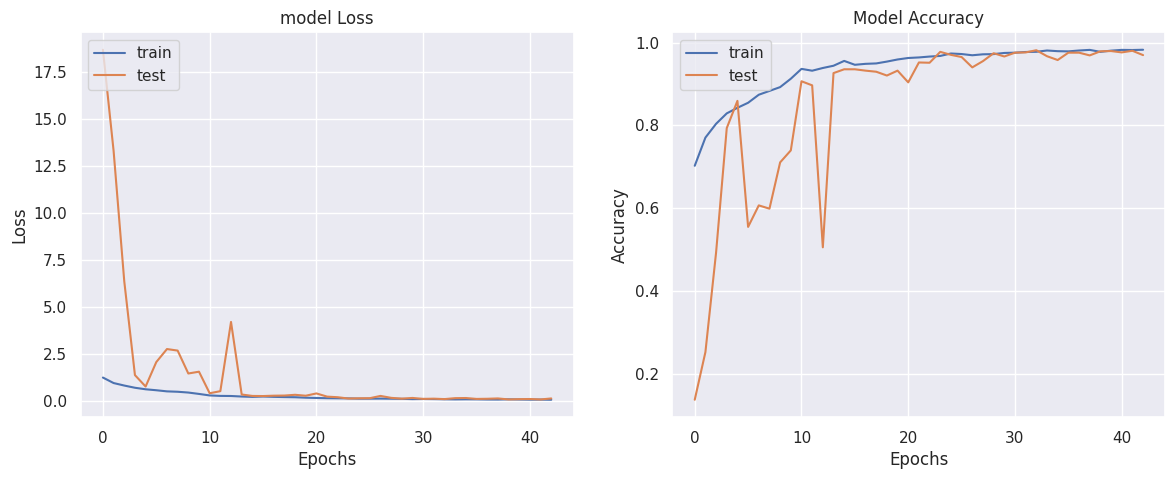

In [38]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model Evaluation¶

In [39]:
train_loss, train_accu = model.evaluate(X_train, Y_train)
test_loss, test_accu = model.evaluate(X_test, Y_test)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

48/48 [==============================] - 1s 20ms/step - loss: 0.1223 - accuracy: 0.9816
final train accuracy = 99.88 , validation accuracy = 98.16


> **Excellent accuracy is achieved on training set and  validation set 💪**

### Confusion Matrix and Classification on training set

In [40]:
def confusion_mat(X, y):
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=1)
    y_target = np.argmax(y, axis=1)
    target_names = label_encoder.classes_
    
    print('Classification Report')
    target_names = label_encoder.classes_
    print(classification_report(y_target, y_pred, target_names=target_names))
    
    print('Confusion Matrix')
    cm_train = confusion_matrix(y_target , y_pred)
    print(cm_train)
    
    plt.figure(figsize=(5,5))
    plt.imshow(cm_train, interpolation='nearest')
    plt.colorbar()
    tick_mark = np.arange(len(target_names))
    _ = plt.xticks(tick_mark, target_names, rotation=90)
    _ = plt.yticks(tick_mark, target_names)

190/190 [==============================] - 4s 19ms/step
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       476
           1       1.00      1.00      1.00       450
           2       1.00      1.00      1.00       346
           3       1.00      1.00      1.00       433
           4       1.00      1.00      1.00       421
           5       1.00      1.00      1.00       346
           6       0.99      1.00      1.00       465
           7       1.00      1.00      1.00       426
           8       1.00      1.00      1.00       443
           9       1.00      1.00      1.00       437
         add       1.00      1.00      1.00       477
         div       1.00      1.00      1.00       374
         mul       1.00      1.00      1.00       462
         sub       1.00      1.00      1.00       524

    accuracy                           1.00      6080
   macro avg       1.00      1.00      1.00      6080
we

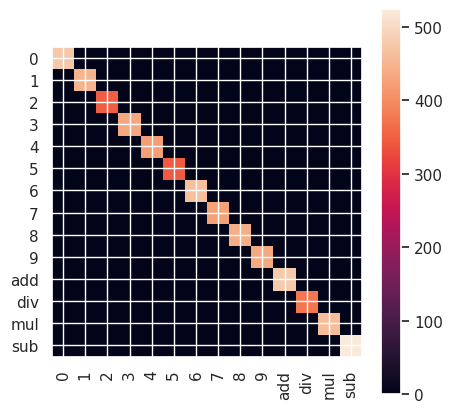

In [41]:
# Train Set
confusion_mat(X_train,Y_train)

48/48 [==============================] - 1s 19ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       119
           1       0.98      0.98      0.98       112
           2       0.99      0.97      0.98        87
           3       0.92      0.98      0.95       108
           4       0.98      0.97      0.98       105
           5       1.00      0.95      0.98        87
           6       0.98      1.00      0.99       116
           7       0.99      0.96      0.98       107
           8       0.97      0.96      0.97       111
           9       0.98      0.97      0.98       109
         add       1.00      0.98      0.99       119
         div       1.00      1.00      1.00        94
         mul       1.00      0.99      1.00       115
         sub       0.99      1.00      1.00       131

    accuracy                           0.98      1520
   macro avg       0.98      0.98      0.98      1520
weig

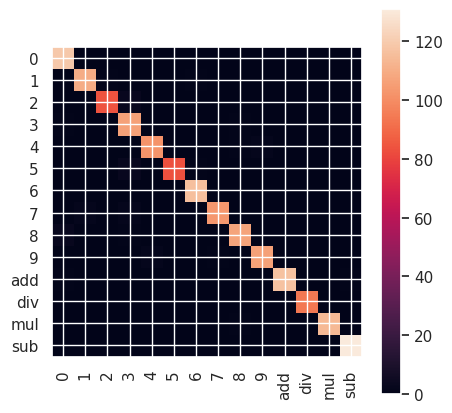

In [42]:
# Test Set
confusion_mat(X_test,Y_test)

---
# Test the model


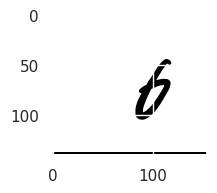

In [106]:
# Get test image
image = cv2.imread(r'/kaggle/working/data/dataset/6/66036.jpg',cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(2, 2))
plt.imshow(image,cmap='gray')
plt.show()

In [112]:
def image_preprocessing(image):
    image = cv2.resize(image, (32, 32))
    arrim = np.array(image)
    arrim = np.expand_dims(arrim, axis=-1)
    arrim = arrim/255.
    arrim = np.array([np.array(arrim)])
    return arrim

In [113]:
# Make a prediction
prediction = model.predict(image_preprocessing(image))
prediction

1/1 [==============================] - 0s 21ms/step


array([[6.8241379e-06, 5.1320498e-10, 4.9319219e-11, 4.3080459e-11,
        4.7653426e-08, 9.6129131e-09, 9.9989963e-01, 1.6167316e-11,
        9.3426832e-05, 9.7067710e-12, 4.6209900e-13, 6.5870490e-12,
        1.1828099e-08, 5.2172554e-17]], dtype=float32)

In [114]:
label_encoder.classes_[np.argmax(prediction)]

'6'

In [249]:
def model_test(image_path):    
    chars = []
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (800, 800))
    # blurred = cv2.GaussianBlur(img_gray, (3, 3), 0)
    edged = cv2.Canny(img, 30, 150)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sort_contours(contours, method="left-to-right")[0]
    
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if 20<=w and 30<=h:
            # Substract Symbole from image 
            roi = img[y:y+h, x:x+w]
            
            # Calculate padding we put for image
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw)/2.0)
            dy = int(max(0, 32 - th) / 2.0)
            
            #Put pad to the image
            padded = cv2.copyMakeBorder(thresh, top=dx, bottom=dx, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT,
                                       value=(254, 254, 254))
            
            # Show the symbole
            plt.figure(figsize=(2, 2))
            plt.imshow(padded,cmap='gray')
            plt.axis('off')
            plt.show()
            
            # predict
            pred = model.predict(image_preprocessing(padded))
            label = label_encoder.classes_[np.argmax(pred)]
            chars.append(label)
            print("Predict: ",label,end="\n"*5)
            
            # Put rectangle on the image on each symbole
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    # Display the image
    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    # Define a dictionary to map labels to operators
    operator_mapping = {'add': '+', 'sub': '-', 'mul': '*', 'div': '/'}
    expression = ''.join(operator_mapping.get(label, label) for label in chars)

    result = eval(expression)
    
    print('Value of the expression {}: {}'.format(expression, result))


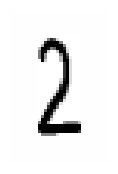

1/1 [==============================] - 0s 24ms/step
Predict:  2






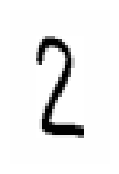

1/1 [==============================] - 0s 23ms/step
Predict:  2






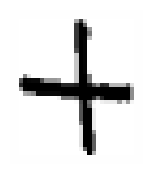

1/1 [==============================] - 0s 23ms/step
Predict:  add






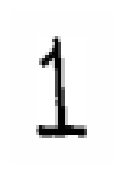

1/1 [==============================] - 0s 24ms/step
Predict:  1






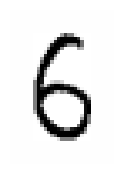

1/1 [==============================] - 0s 24ms/step
Predict:  6






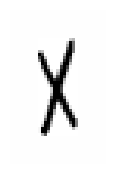

1/1 [==============================] - 0s 24ms/step
Predict:  mul






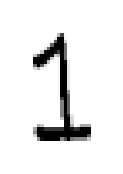

1/1 [==============================] - 0s 24ms/step
Predict:  1






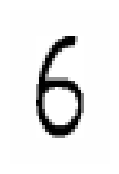

1/1 [==============================] - 0s 23ms/step
Predict:  6






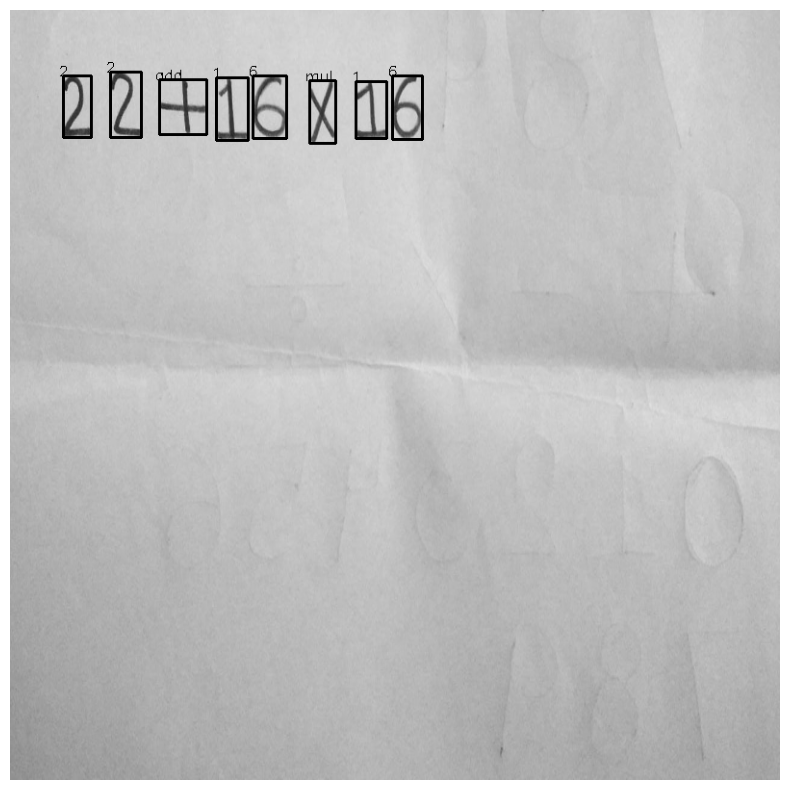

Value of the expression 22+16*16: 278


In [250]:
model_test("/kaggle/working/data/test_equation4.jpg")

### Thanks

**By Osama Mohamed**